Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=f29633fe8b0dc397c8dc275ff60e0225533712670a02949feed2186270ea03b2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['B-Chemical', 'I-Disease', 'I-Chemical', 'O', 'B-Disease']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['B-Chemical', 'I-Disease', 'I-Chemical', 'O', 'B-Disease']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['B-Chemical', 'I-Disease', 'I-Chemical', 'O', 'B-Disease']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

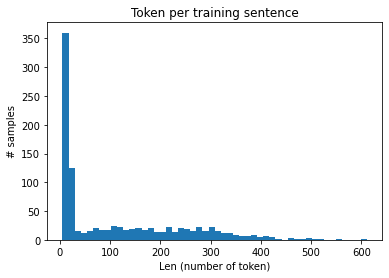

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

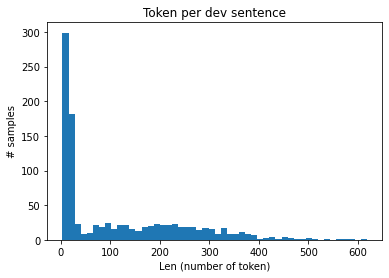

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

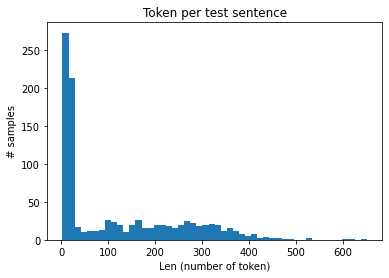

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'incidence'
print(word2idx['incidence'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Disease'
print(tag2idx['B-Disease'])
# Tag of index 4
print(idx2tag[4])

15894
Inbred
4
B-Disease


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 500
Points in y_train before removal: 500


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6228, 1874, 11906, 8738, 5575, 1874, 5581, 15205, 7439, 12071, 2857, 18506, 18018, 12071, 15008, 15336, 7439, 13207, 12266, 11654, 3602, 11706, 12410, 15087, 3602, 490, 8738, 351, 15205, 5289, 394, 1598, 13634, 3602, 5575, 1874, 5581, 15962, 465, 13541, 15087, 3602, 351, 1874, 3985, 16938, 13472, 394, 1598, 13634, 3602, 5575, 1874, 5581, 8738, 1919, 8893, 11542, 4875, 3079, 15205, 4875, 5853, 5007, 3090, 7439, 12071, 8189, 18018, 1967, 3602, 16511, 12410, 1874, 6923, 10832, 4319, 11053, 17068, 7302, 9935, 15962, 13472, 394, 1598, 10181, 8436, 18018, 8857, 4754, 4608, 8391, 5575, 1874, 5581, 4875, 12216, 8098, 1598, 12071, 8436, 18018, 5575, 1874, 5581, 7439, 12071, 11695, 18018, 12410, 1874, 6923, 10832, 4319, 1346, 7439, 3112, 18018, 2366, 9056, 7439, 16073, 13472, 394, 1598, 5575, 1874, 5581, 13904, 17629, 1967, 4319, 8642, 4875, 17328, 11695, 2817, 3602, 351, 15962, 3177, 8738, 7074, 15205, 4319, 12565, 3833, 2114, 11913, 7439, 12410, 11695, 2817, 3602, 5289, 1874, 11721, 17962, 87

In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[6228, 1874, 11906, 8738, 5575, 1874, 5581, 15205, 7439, 12071, 2857, 18506, 18018, 12071, 15008, 15336, 7439, 13207, 12266, 11654, 3602, 11706, 12410, 15087, 3602, 490, 8738, 351, 15205, 5289, 394, 1598, 13634, 3602, 5575, 1874, 5581, 15962, 465, 13541, 15087, 3602, 351, 1874, 3985, 16938, 13472, 394, 1598, 13634, 3602, 5575, 1874, 5581, 8738, 1919, 8893, 11542, 4875, 3079, 15205, 4875, 5853, 5007, 3090, 7439, 12071, 8189, 18018, 1967, 3602, 16511, 12410, 1874, 6923, 10832, 4319, 11053, 17068, 7302, 9935, 15962, 13472, 394, 1598, 10181, 8436, 18018, 8857, 4754, 4608, 8391, 5575, 1874, 5581, 4875, 12216, 8098, 1598, 12071, 8

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6922385692596436
Training loss epoch: 0.30481153982691467
Training accuracy epoch: 0.9062012245050104
Validating model...
Validation Loss: 0.10870319699484204
Validation Accuracy: 0.9637753462706568
Training epoch: 2
Training loss per 100 training steps: 0.1265527606010437
Training loss epoch: 0.08666366920806468
Training accuracy epoch: 0.9714852247942055
Validating model...
Validation Loss: 0.08000285225728201
Validation Accuracy: 0.9726933075638692
Training epoch: 3
Training loss per 100 training steps: 0.040679555386304855
Training loss epoch: 0.04580452383379452
Training accuracy epoch: 0.9853175201984156
Validating model...
Validation Loss: 0.08385059101477502
Validation Accuracy: 0.9727132076697215
Training epoch: 4
Training loss per 100 training steps: 0.03312771022319794
Training loss epoch: 0.026295373478205875
Training accuracy epoch: 0.9920666879425077
Validating model...
Validation Loss: 0.08915258139844924
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08003491583088088
Validation Accuracy: 0.9735421370541991
Validation duration: 0.2450599166666668 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.88      0.92      0.90      4985
     Disease       0.77      0.79      0.78      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.83      0.86      0.84      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5354763269424438
Training loss epoch: 0.3015647584106773
Training accuracy epoch: 0.9108819642096191
Validating model...
Validation Loss: 0.12286488286086492
Validation Accuracy: 0.95898121230975
Training epoch: 2
Training loss per 100 training steps: 0.09692665189504623
Training loss epoch: 0.09526044735684991
Training accuracy epoch: 0.968357034513696
Validating model...
Validation Loss: 0.08581919908996612
Validation Accuracy: 0.9699980184942383
Training epoch: 3
Training loss per 100 training steps: 0.0737396627664566
Training loss epoch: 0.0464602664578706
Training accuracy epoch: 0.9855518362277877
Validating model...
Validation Loss: 0.07732752243441249
Validation Accuracy: 0.9743965228553629
Training epoch: 4
Training loss per 100 training steps: 0.022345861420035362
Training loss epoch: 0.02620073055732064
Training accuracy epoch: 0.9917431836256831
Validating model...
Validation Loss: 0.08454501705746802
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0790469835083636
Validation Accuracy: 0.9746076143077925
Validation duration: 0.24439633333333385 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.90      4985
     Disease       0.75      0.81      0.78      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9396066665649414
Training loss epoch: 0.31819264381192625
Training accuracy epoch: 0.902562725773572
Validating model...
Validation Loss: 0.11153002757401694
Validation Accuracy: 0.9624071102443454
Training epoch: 2
Training loss per 100 training steps: 0.08855187147855759
Training loss epoch: 0.08574634866090491
Training accuracy epoch: 0.9709817420984563
Validating model...
Validation Loss: 0.0811387367901348
Validation Accuracy: 0.972373395415399
Training epoch: 3
Training loss per 100 training steps: 0.0414222776889801
Training loss epoch: 0.04447797389002517
Training accuracy epoch: 0.9853935484189906
Validating model...
Validation Loss: 0.08490982415184142
Validation Accuracy: 0.971394686449385
Training epoch: 4
Training loss per 100 training steps: 0.01891377754509449
Training loss epoch: 0.026548835245193914
Training accuracy epoch: 0.9918118391786511
Validating model...
Validation Loss: 0.08623846182747492
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08255017460102126
Validation Accuracy: 0.9719355846724581
Validation duration: 0.24404113333333347 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

    Chemical       0.87      0.93      0.90      4985
     Disease       0.70      0.81      0.75      4416

   micro avg       0.79      0.87      0.83      9401
   macro avg       0.79      0.87      0.82      9401
weighted avg       0.79      0.87      0.83      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5326592922210693
Training loss epoch: 0.2794371144846082
Training accuracy epoch: 0.9141028426388534
Validating model...
Validation Loss: 0.11079635772676695
Validation Accuracy: 0.9631706686123308
Training epoch: 2
Training loss per 100 training steps: 0.0671730786561966
Training loss epoch: 0.08226020645815879
Training accuracy epoch: 0.9736670973398016
Validating model...
Validation Loss: 0.08099730005339971
Validation Accuracy: 0.9727617990915026
Training epoch: 3
Training loss per 100 training steps: 0.060767509043216705
Training loss epoch: 0.03954677999718115
Training accuracy epoch: 0.9875711464996472
Validating model...
Validation Loss: 0.07995794775585334
Validation Accuracy: 0.9758846870982875
Training epoch: 4
Training loss per 100 training steps: 0.01761680655181408
Training loss epoch: 0.024345938814803958
Training accuracy epoch: 0.9927181602618459
Validating model...
Validation Loss: 0.08573222308168335
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08114061096594447
Validation Accuracy: 0.9757367798773235
Validation duration: 0.2427166333333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.9%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.91      4985
     Disease       0.76      0.80      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.83      0.86      0.85      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7805185317993164
Training loss epoch: 0.2996299124788493
Training accuracy epoch: 0.9044061111807657
Validating model...
Validation Loss: 0.10778059006210357
Validation Accuracy: 0.9624545071626914
Training epoch: 2
Training loss per 100 training steps: 0.11522061377763748
Training loss epoch: 0.08299434510990977
Training accuracy epoch: 0.9728664964434494
Validating model...
Validation Loss: 0.08756824032891364
Validation Accuracy: 0.9693751602098405
Training epoch: 3
Training loss per 100 training steps: 0.03121938370168209
Training loss epoch: 0.04520434758160263
Training accuracy epoch: 0.9848645939650064
Validating model...
Validation Loss: 0.07890701101767639
Validation Accuracy: 0.9737628873679643
Training epoch: 4
Training loss per 100 training steps: 0.02061336487531662
Training loss epoch: 0.026477965991944075
Training accuracy epoch: 0.9916131414364546
Validating model...
Validation Loss: 0.08467533924276867
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08299030907570369
Validation Accuracy: 0.9731613613523427
Validation duration: 0.24552704999999833 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.9%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.75      0.82      0.78      4416

   micro avg       0.82      0.88      0.85      9401
   macro avg       0.82      0.87      0.85      9401
weighted avg       0.82      0.88      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7320053577423096
Training loss epoch: 0.29151064611505717
Training accuracy epoch: 0.9080289886704818
Validating model...
Validation Loss: 0.11790385735886437
Validation Accuracy: 0.9591790168661709
Training epoch: 2
Training loss per 100 training steps: 0.14263057708740234
Training loss epoch: 0.08245864894706756
Training accuracy epoch: 0.9729986334510077
Validating model...
Validation Loss: 0.09255093306539551
Validation Accuracy: 0.9674061646708398
Training epoch: 3
Training loss per 100 training steps: 0.06331329047679901
Training loss epoch: 0.044234611676074564
Training accuracy epoch: 0.9855850797312858
Validating model...
Validation Loss: 0.08099953099966996
Validation Accuracy: 0.9752069638781921
Training epoch: 4
Training loss per 100 training steps: 0.024593930691480637
Training loss epoch: 0.02397276961710304
Training accuracy epoch: 0.9926274044491541
Validating model...
Validation Loss: 0.08942587780100959
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08269676146289659
Validation Accuracy: 0.9746602017427667
Validation duration: 0.2442667999999988 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.91      4985
     Disease       0.77      0.80      0.78      4416

   micro avg       0.83      0.86      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9209693670272827
Training loss epoch: 0.3100707868579775
Training accuracy epoch: 0.9038207147134747
Validating model...
Validation Loss: 0.1127196533812417
Validation Accuracy: 0.9627000054487056
Training epoch: 2
Training loss per 100 training steps: 0.1786775439977646
Training loss epoch: 0.08440274489112198
Training accuracy epoch: 0.9716326827734355
Validating model...
Validation Loss: 0.07629424972193581
Validation Accuracy: 0.9742849259997711
Training epoch: 3
Training loss per 100 training steps: 0.05355267599225044
Training loss epoch: 0.04652533825719729
Training accuracy epoch: 0.9847423538407333
Validating model...
Validation Loss: 0.07673739074241548
Validation Accuracy: 0.9749505614834183
Training epoch: 4
Training loss per 100 training steps: 0.024782728403806686
Training loss epoch: 0.028716191241983324
Training accuracy epoch: 0.9915855033144255
Validating model...
Validation Loss: 0.0898031529689592
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07887032208225084
Validation Accuracy: 0.9734188726943058
Validation duration: 0.24411146666666733 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.89      0.91      0.90      4985
     Disease       0.77      0.79      0.78      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.83      0.86      0.84      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6032205820083618
Training loss epoch: 0.2946631144732237
Training accuracy epoch: 0.9104832368714931
Validating model...
Validation Loss: 0.11163314573821567
Validation Accuracy: 0.9614982118879144
Training epoch: 2
Training loss per 100 training steps: 0.10688532143831253
Training loss epoch: 0.08077283867169172
Training accuracy epoch: 0.9735152231955277
Validating model...
Validation Loss: 0.07958239263721875
Validation Accuracy: 0.9718336653937333
Training epoch: 3
Training loss per 100 training steps: 0.0527065210044384
Training loss epoch: 0.04072604450630024
Training accuracy epoch: 0.9872293042913627
Validating model...
Validation Loss: 0.07872495900780435
Validation Accuracy: 0.97413604636264
Training epoch: 4
Training loss per 100 training steps: 0.020126691088080406
Training loss epoch: 0.02429715738981031
Training accuracy epoch: 0.9930965540004278
Validating model...
Validation Loss: 0.08542103556886552
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08424015733457747
Validation Accuracy: 0.9729617674094427
Validation duration: 0.24562535000000024 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

    Chemical       0.93      0.87      0.90      4985
     Disease       0.72      0.81      0.76      4416

   micro avg       0.82      0.84      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.84      0.83      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6376558542251587
Training loss epoch: 0.3095463062636554
Training accuracy epoch: 0.9067526731351045
Validating model...
Validation Loss: 0.11273504557117583
Validation Accuracy: 0.9631848641420526
Training epoch: 2
Training loss per 100 training steps: 0.10555882006883621
Training loss epoch: 0.08356673084199429
Training accuracy epoch: 0.9720567394479963
Validating model...
Validation Loss: 0.08520700433661067
Validation Accuracy: 0.9720076984749423
Training epoch: 3
Training loss per 100 training steps: 0.060580361634492874
Training loss epoch: 0.04813149379333481
Training accuracy epoch: 0.984837691422813
Validating model...
Validation Loss: 0.07935984672180244
Validation Accuracy: 0.974712053801154
Training epoch: 4
Training loss per 100 training steps: 0.05467028170824051
Training loss epoch: 0.02677817174117081
Training accuracy epoch: 0.9917987344094228
Validating model...
Validation Loss: 0.0842669837708984
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08337286132432166
Validation Accuracy: 0.9741172404340114
Validation duration: 0.24640564999999698 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.9%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.76      0.81      0.78      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.82      0.87      0.85      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8831462860107422
Training loss epoch: 0.3179460015380755
Training accuracy epoch: 0.9012931194442302
Validating model...
Validation Loss: 0.11167173560649629
Validation Accuracy: 0.9622853041955438
Training epoch: 2
Training loss per 100 training steps: 0.09993621706962585
Training loss epoch: 0.08881696802563965
Training accuracy epoch: 0.9698353050529175
Validating model...
Validation Loss: 0.08187009985484774
Validation Accuracy: 0.9719036560325651
Training epoch: 3
Training loss per 100 training steps: 0.04869651794433594
Training loss epoch: 0.045297007367480546
Training accuracy epoch: 0.9851143455964337
Validating model...
Validation Loss: 0.0880489433332095
Validation Accuracy: 0.9717534395869378
Training epoch: 4
Training loss per 100 training steps: 0.03280559927225113
Training loss epoch: 0.022302883968222886
Training accuracy epoch: 0.9935008322149317
Validating model...
Validation Loss: 0.094146336295775
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08249941728417835
Validation Accuracy: 0.9723633343890948
Validation duration: 0.24739188333333004 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.87      0.92      0.89      4985
     Disease       0.75      0.79      0.77      4416

   micro avg       0.81      0.86      0.84      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.81      0.86      0.84      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8915170431137085
Training loss epoch: 0.26708179637789725
Training accuracy epoch: 0.9145300186016166
Validating model...
Validation Loss: 0.09512713776221352
Validation Accuracy: 0.9674623563185444
Training epoch: 2
Training loss per 100 training steps: 0.07309622317552567
Training loss epoch: 0.07351803360506892
Training accuracy epoch: 0.9764510755766558
Validating model...
Validation Loss: 0.07769248906582121
Validation Accuracy: 0.9737995220826907
Training epoch: 3
Training loss per 100 training steps: 0.03305768966674805
Training loss epoch: 0.04455116828903556
Training accuracy epoch: 0.9869950858218106
Validating model...
Validation Loss: 0.08313565452893575
Validation Accuracy: 0.9725212429600203
Training epoch: 4
Training loss per 100 training steps: 0.01198518555611372
Training loss epoch: 0.029588896105997263
Training accuracy epoch: 0.9907725559927721
Validating model...
Validation Loss: 0.08285073356495963
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08065725948720698
Validation Accuracy: 0.9732592889511053
Validation duration: 0.24658821666666123 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

    Chemical       0.90      0.90      0.90      4985
     Disease       0.75      0.79      0.77      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.83      0.84      0.83      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6671295166015625
Training loss epoch: 0.25900207087397575
Training accuracy epoch: 0.9177816332929639
Validating model...
Validation Loss: 0.09764268887894494
Validation Accuracy: 0.967130172163932
Training epoch: 2
Training loss per 100 training steps: 0.07721512764692307
Training loss epoch: 0.08151215314865112
Training accuracy epoch: 0.9698472884888686
Validating model...
Validation Loss: 0.0807182105878989
Validation Accuracy: 0.9712319403857737
Training epoch: 3
Training loss per 100 training steps: 0.0556107759475708
Training loss epoch: 0.049534629378467795
Training accuracy epoch: 0.983604166419512
Validating model...
Validation Loss: 0.09033641999676115
Validation Accuracy: 0.9715033730563394
Training epoch: 4
Training loss per 100 training steps: 0.03106960654258728
Training loss epoch: 0.04151428358163685
Training accuracy epoch: 0.9867495418442159
Validating model...
Validation Loss: 0.087561979121159
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0856048995776782
Validation Accuracy: 0.9704181183152568
Validation duration: 0.24578393333333678 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.71      0.81      0.76      4416

   micro avg       0.81      0.87      0.84      9401
   macro avg       0.81      0.86      0.83      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8763208389282227
Training loss epoch: 0.26932655423879626
Training accuracy epoch: 0.9153490689762126
Validating model...
Validation Loss: 0.09522554568118519
Validation Accuracy: 0.9674720183302083
Training epoch: 2
Training loss per 100 training steps: 0.09017487615346909
Training loss epoch: 0.07495420621708035
Training accuracy epoch: 0.9748720976602486
Validating model...
Validation Loss: 0.09913526067421549
Validation Accuracy: 0.9648959628161727
Training epoch: 3
Training loss per 100 training steps: 0.06882340461015701
Training loss epoch: 0.04481944525614381
Training accuracy epoch: 0.9855313502037303
Validating model...
Validation Loss: 0.07952150229423766
Validation Accuracy: 0.9749799992452536
Training epoch: 4
Training loss per 100 training steps: 0.018358193337917328
Training loss epoch: 0.02298262739786878
Training accuracy epoch: 0.993541407844801
Validating model...
Validation Loss: 0.09483724572355785
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08459104094949979
Validation Accuracy: 0.974098674638562
Validation duration: 0.2447516999999986 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.76      0.80      0.78      4416

   micro avg       0.85      0.86      0.85      9401
   macro avg       0.84      0.85      0.85      9401
weighted avg       0.85      0.86      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4186806678771973
Training loss epoch: 0.24638191275298596
Training accuracy epoch: 0.9259682918372982
Validating model...
Validation Loss: 0.0982268884896286
Validation Accuracy: 0.9667371612836474
Training epoch: 2
Training loss per 100 training steps: 0.07285185903310776
Training loss epoch: 0.06965818025637419
Training accuracy epoch: 0.9776332640704037
Validating model...
Validation Loss: 0.08088197393549813
Validation Accuracy: 0.9737534783138412
Training epoch: 3
Training loss per 100 training steps: 0.043573684990406036
Training loss epoch: 0.03464122901204973
Training accuracy epoch: 0.9887289202617013
Validating model...
Validation Loss: 0.08499859350304755
Validation Accuracy: 0.9737982395220551
Training epoch: 4
Training loss per 100 training steps: 0.03066878207027912
Training loss epoch: 0.01978912316262722
Training accuracy epoch: 0.9938771283335379
Validating model...
Validation Loss: 0.09002814010258704
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08116613109669989
Validation Accuracy: 0.9738273837555763
Validation duration: 0.24574403333333522 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.79      0.76      0.77      4416

   micro avg       0.85      0.84      0.85      9401
   macro avg       0.84      0.84      0.84      9401
weighted avg       0.85      0.84      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.128143310546875
Training loss epoch: 0.2815286649391055
Training accuracy epoch: 0.9162723172145659
Validating model...
Validation Loss: 0.1006845212763264
Validation Accuracy: 0.9660751581891724
Training epoch: 2
Training loss per 100 training steps: 0.0658612921833992
Training loss epoch: 0.0712986869737506
Training accuracy epoch: 0.977465998823688
Validating model...
Validation Loss: 0.08113383481072055
Validation Accuracy: 0.9726951180974784
Training epoch: 3
Training loss per 100 training steps: 0.0422893762588501
Training loss epoch: 0.04111714065074921
Training accuracy epoch: 0.9874228245809065
Validating model...
Validation Loss: 0.0833729635628443
Validation Accuracy: 0.9734111933801647
Training epoch: 4
Training loss per 100 training steps: 0.03428275138139725
Training loss epoch: 0.02101177293807268
Training accuracy epoch: 0.9937347497995649
Validating model...
Validation Loss: 0.09136203262541029
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08610705380874967
Validation Accuracy: 0.9720567761248798
Validation duration: 0.24636706666666822 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.87      0.89      4985
     Disease       0.76      0.76      0.76      4416

   micro avg       0.85      0.82      0.83      9401
   macro avg       0.84      0.81      0.83      9401
weighted avg       0.85      0.82      0.83      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7695833444595337
Training loss epoch: 0.26027390379458665
Training accuracy epoch: 0.9180374183171054
Validating model...
Validation Loss: 0.09815955026045678
Validation Accuracy: 0.9674674243565938
Training epoch: 2
Training loss per 100 training steps: 0.07581114768981934
Training loss epoch: 0.07847627988085151
Training accuracy epoch: 0.9763482713389744
Validating model...
Validation Loss: 0.0924791002439128
Validation Accuracy: 0.9703396514049277
Training epoch: 3
Training loss per 100 training steps: 0.06303229928016663
Training loss epoch: 0.05237468550913036
Training accuracy epoch: 0.9830250140967737
Validating model...
Validation Loss: 0.0833794613560987
Validation Accuracy: 0.97285445941739
Training epoch: 4
Training loss per 100 training steps: 0.029832789674401283
Training loss epoch: 0.02662003647419624
Training accuracy epoch: 0.991483805314101
Validating model...
Validation Loss: 0.08604914434845486
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08685893234279421
Validation Accuracy: 0.9729396767187711
Validation duration: 0.2458946666666634 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.91      4985
     Disease       0.74      0.80      0.77      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.83      0.84      0.84      9401
weighted avg       0.84      0.85      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4363347291946411
Training loss epoch: 0.2483121694996953
Training accuracy epoch: 0.9252378963702956
Validating model...
Validation Loss: 0.0978036162162584
Validation Accuracy: 0.9664670942583654
Training epoch: 2
Training loss per 100 training steps: 0.11974893510341644
Training loss epoch: 0.07463568337261677
Training accuracy epoch: 0.97459662364241
Validating model...
Validation Loss: 0.07999516757471221
Validation Accuracy: 0.9731564302554395
Training epoch: 3
Training loss per 100 training steps: 0.04602205008268356
Training loss epoch: 0.04407361755147576
Training accuracy epoch: 0.9861336706913452
Validating model...
Validation Loss: 0.08965379035189039
Validation Accuracy: 0.9713113066256756
Training epoch: 4
Training loss per 100 training steps: 0.030087364837527275
Training loss epoch: 0.025248872768133878
Training accuracy epoch: 0.9923810399459935
Validating model...
Validation Loss: 0.08908825184381197
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08586137517104073
Validation Accuracy: 0.9715502235850848
Validation duration: 0.24355233333333975 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

    Chemical       0.87      0.92      0.90      4985
     Disease       0.70      0.80      0.75      4416

   micro avg       0.79      0.87      0.83      9401
   macro avg       0.79      0.86      0.82      9401
weighted avg       0.79      0.87      0.83      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4509316682815552
Training loss epoch: 0.2509061906952411
Training accuracy epoch: 0.9251163853222458
Validating model...
Validation Loss: 0.10735235286373941
Validation Accuracy: 0.9636332962019246
Training epoch: 2
Training loss per 100 training steps: 0.08831674605607986
Training loss epoch: 0.07048315582796931
Training accuracy epoch: 0.9763092993682816
Validating model...
Validation Loss: 0.0809501473984075
Validation Accuracy: 0.9733085208218488
Training epoch: 3
Training loss per 100 training steps: 0.017294099554419518
Training loss epoch: 0.03688164846971631
Training accuracy epoch: 0.9877966573283752
Validating model...
Validation Loss: 0.08140834568748398
Validation Accuracy: 0.9743603286580567
Training epoch: 4
Training loss per 100 training steps: 0.064097099006176
Training loss epoch: 0.020640912535600364
Training accuracy epoch: 0.9938082452183018
Validating model...
Validation Loss: 0.09036544846400382
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07902128001054128
Validation Accuracy: 0.9739869071143705
Validation duration: 0.24582024999999702 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.91      4985
     Disease       0.77      0.78      0.77      4416

   micro avg       0.85      0.84      0.84      9401
   macro avg       0.84      0.83      0.84      9401
weighted avg       0.85      0.84      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5644296407699585
Training loss epoch: 0.2623692572116852
Training accuracy epoch: 0.9206318078985261
Validating model...
Validation Loss: 0.10370394179508799
Validation Accuracy: 0.9659436130544533
Training epoch: 2
Training loss per 100 training steps: 0.10654105991125107
Training loss epoch: 0.07770374743267894
Training accuracy epoch: 0.9751721196773545
Validating model...
Validation Loss: 0.08182181784557918
Validation Accuracy: 0.9721291922500421
Training epoch: 3
Training loss per 100 training steps: 0.042427536100149155
Training loss epoch: 0.04240877013653517
Training accuracy epoch: 0.986635067719764
Validating model...
Validation Loss: 0.087798993561476
Validation Accuracy: 0.9707122540880383
Training epoch: 4
Training loss per 100 training steps: 0.020141664892435074
Training loss epoch: 0.025843715271912517
Training accuracy epoch: 0.9920808237599006
Validating model...
Validation Loss: 0.09739630072126312
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08417743485834864
Validation Accuracy: 0.9715338903876017
Validation duration: 0.24785426666665747 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.85      0.94      0.89      4985
     Disease       0.73      0.81      0.77      4416

   micro avg       0.79      0.88      0.83      9401
   macro avg       0.79      0.87      0.83      9401
weighted avg       0.79      0.88      0.83      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9077001810073853
Training loss epoch: 0.2940694816410542
Training accuracy epoch: 0.9085628805101787
Validating model...
Validation Loss: 0.1078728134078639
Validation Accuracy: 0.9628467997075001
Training epoch: 2
Training loss per 100 training steps: 0.12376817315816879
Training loss epoch: 0.08364862306043505
Training accuracy epoch: 0.9718713099578654
Validating model...
Validation Loss: 0.09012557081286869
Validation Accuracy: 0.9702565695253714
Training epoch: 3
Training loss per 100 training steps: 0.04494679719209671
Training loss epoch: 0.060204432578757405
Training accuracy epoch: 0.9820640109589567
Validating model...
Validation Loss: 0.08454085898304743
Validation Accuracy: 0.9727266424728532
Training epoch: 4
Training loss per 100 training steps: 0.02880287542939186
Training loss epoch: 0.04416712513193488
Training accuracy epoch: 0.9860616860702061
Validating model...
Validation Loss: 0.0958064157693159
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0869797867914987
Validation Accuracy: 0.9722338329438315
Validation duration: 0.24671573333333374 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.90      0.90      4985
     Disease       0.76      0.73      0.74      4416

   micro avg       0.84      0.82      0.83      9401
   macro avg       0.83      0.81      0.82      9401
weighted avg       0.83      0.82      0.83      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3584171533584595
Training loss epoch: 0.21522689563162783
Training accuracy epoch: 0.9342127302562149
Validating model...
Validation Loss: 0.10164721818670394
Validation Accuracy: 0.965204888184802
Training epoch: 2
Training loss per 100 training steps: 0.06452751159667969
Training loss epoch: 0.06085661929497059
Training accuracy epoch: 0.9804853550615424
Validating model...
Validation Loss: 0.07839550893931162
Validation Accuracy: 0.9736554821220358
Training epoch: 3
Training loss per 100 training steps: 0.0332770012319088
Training loss epoch: 0.027835133445865298
Training accuracy epoch: 0.9910479172605038
Validating model...
Validation Loss: 0.08677700927688016
Validation Accuracy: 0.9745439146579781
Training epoch: 4
Training loss per 100 training steps: 0.007646653335541487
Training loss epoch: 0.013878985030695479
Training accuracy epoch: 0.9958253536234314
Validating model...
Validation Loss: 0.10476107647021611
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08138851969251557
Validation Accuracy: 0.9727649669950608
Validation duration: 0.24503525000000081 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.89      0.91      0.90      4985
     Disease       0.72      0.79      0.75      4416

   micro avg       0.81      0.86      0.83      9401
   macro avg       0.80      0.85      0.83      9401
weighted avg       0.81      0.86      0.83      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6237353086471558
Training loss epoch: 0.22615377383029206
Training accuracy epoch: 0.9285170179235942
Validating model...
Validation Loss: 0.09368461790302443
Validation Accuracy: 0.968454144382931
Training epoch: 2
Training loss per 100 training steps: 0.09155192971229553
Training loss epoch: 0.061639512710748835
Training accuracy epoch: 0.9799528955671926
Validating model...
Validation Loss: 0.08562928231226073
Validation Accuracy: 0.9718605518968935
Training epoch: 3
Training loss per 100 training steps: 0.027690766379237175
Training loss epoch: 0.028575837731044343
Training accuracy epoch: 0.9911210304635291
Validating model...
Validation Loss: 0.09473228359979297
Validation Accuracy: 0.9724210251550425
Training epoch: 4
Training loss per 100 training steps: 0.03447455167770386
Training loss epoch: 0.016015320461481176
Training accuracy epoch: 0.9952085364346105
Validating model...
Validation Loss: 0.09577988460659981
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08643784468609189
Validation Accuracy: 0.9725283359014217
Validation duration: 0.24504249999999955 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.91      0.89      0.90      4985
     Disease       0.79      0.74      0.77      4416

   micro avg       0.86      0.82      0.84      9401
   macro avg       0.85      0.82      0.83      9401
weighted avg       0.85      0.82      0.84      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8446495532989502
Training loss epoch: 0.24562115222215652
Training accuracy epoch: 0.9236731200180787
Validating model...
Validation Loss: 0.09675391337701253
Validation Accuracy: 0.967594407629872
Training epoch: 2
Training loss per 100 training steps: 0.09047447144985199
Training loss epoch: 0.06661938844209021
Training accuracy epoch: 0.977977502693279
Validating model...
Validation Loss: 0.08189620597968025
Validation Accuracy: 0.973067465925375
Training epoch: 3
Training loss per 100 training steps: 0.04197126254439354
Training loss epoch: 0.0303136921349041
Training accuracy epoch: 0.99041640638738
Validating model...
Validation Loss: 0.0842685815952127
Validation Accuracy: 0.974222989889424
Training epoch: 4
Training loss per 100 training steps: 0.00973366666585207
Training loss epoch: 0.017513588823853656
Training accuracy epoch: 0.9948170541931304
Validating model...
Validation Loss: 0.09589803969812771
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.085826305288171
Validation Accuracy: 0.9715599333064757
Validation duration: 0.24294948333332891 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.90      4985
     Disease       0.74      0.78      0.76      4416

   micro avg       0.83      0.84      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.84      0.83      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6168566942214966
Training loss epoch: 0.236390694341761
Training accuracy epoch: 0.9250436831639736
Validating model...
Validation Loss: 0.0937402510926837
Validation Accuracy: 0.9683902925313199
Training epoch: 2
Training loss per 100 training steps: 0.07663752883672714
Training loss epoch: 0.0652831791246191
Training accuracy epoch: 0.9786811675093525
Validating model...
Validation Loss: 0.08418614245832913
Validation Accuracy: 0.9714816463174523
Training epoch: 3
Training loss per 100 training steps: 0.040233954787254333
Training loss epoch: 0.03147304929951404
Training accuracy epoch: 0.9898175932951421
Validating model...
Validation Loss: 0.091602809135876
Validation Accuracy: 0.9728404895973154
Training epoch: 4
Training loss per 100 training steps: 0.017993032932281494
Training loss epoch: 0.015938149616518554
Training accuracy epoch: 0.9951732103449411
Validating model...
Validation Loss: 0.09674356870412354
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08687907753009645
Validation Accuracy: 0.9706175970406191
Validation duration: 0.24522731666666003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

    Chemical       0.92      0.88      0.90      4985
     Disease       0.74      0.76      0.75      4416

   micro avg       0.83      0.82      0.83      9401
   macro avg       0.83      0.82      0.83      9401
weighted avg       0.84      0.82      0.83      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.891113519668579
Training loss epoch: 0.23998041260749736
Training accuracy epoch: 0.9225015093659874
Validating model...
Validation Loss: 0.09413686235036169
Validation Accuracy: 0.968265818664781
Training epoch: 2
Training loss per 100 training steps: 0.10251789540052414
Training loss epoch: 0.06196171917179798
Training accuracy epoch: 0.9802345565586581
Validating model...
Validation Loss: 0.07964392993894834
Validation Accuracy: 0.9741158025831752
Training epoch: 3
Training loss per 100 training steps: 0.015440714545547962
Training loss epoch: 0.02928987165239263
Training accuracy epoch: 0.9905423429410743
Validating model...
Validation Loss: 0.0893106824821896
Validation Accuracy: 0.9724942964332166
Training epoch: 4
Training loss per 100 training steps: 0.015885867178440094
Training loss epoch: 0.015600008345109986
Training accuracy epoch: 0.9953449871018938
Validating model...
Validation Loss: 0.09669326807534884
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08373952751594876
Validation Accuracy: 0.9724131451555168
Validation duration: 0.24448213333333418 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

    Chemical       0.88      0.93      0.90      4985
     Disease       0.73      0.80      0.76      4416

   micro avg       0.81      0.87      0.84      9401
   macro avg       0.81      0.86      0.83      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9177706241607666
Training loss epoch: 0.24842489701002202
Training accuracy epoch: 0.922789989752301
Validating model...
Validation Loss: 0.10062772100643506
Validation Accuracy: 0.9649893255008548
Training epoch: 2
Training loss per 100 training steps: 0.07901661843061447
Training loss epoch: 0.06276740149614658
Training accuracy epoch: 0.9795521116551577
Validating model...
Validation Loss: 0.09567302956231057
Validation Accuracy: 0.9677318147807213
Training epoch: 3
Training loss per 100 training steps: 0.05240972340106964
Training loss epoch: 0.03132991017179286
Training accuracy epoch: 0.9899021139387009
Validating model...
Validation Loss: 0.09281555468600894
Validation Accuracy: 0.9728802356120678
Training epoch: 4
Training loss per 100 training steps: 0.009154806844890118
Training loss epoch: 0.016300407168950808
Training accuracy epoch: 0.9948947847093951
Validating model...
Validation Loss: 0.10152678871675143
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09776008229643579
Validation Accuracy: 0.9726989561091074
Validation duration: 0.24172143333333526 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.94      0.87      0.90      4985
     Disease       0.78      0.76      0.77      4416

   micro avg       0.86      0.82      0.84      9401
   macro avg       0.86      0.81      0.84      9401
weighted avg       0.86      0.82      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.78081476688385
Training loss epoch: 0.2380435105333937
Training accuracy epoch: 0.926695415634473
Validating model...
Validation Loss: 0.09493462901030268
Validation Accuracy: 0.9678788360878686
Training epoch: 2
Training loss per 100 training steps: 0.06909293681383133
Training loss epoch: 0.0629758707227859
Training accuracy epoch: 0.9794000017813992
Validating model...
Validation Loss: 0.08163652713927957
Validation Accuracy: 0.9728753181960795
Training epoch: 3
Training loss per 100 training steps: 0.04847521334886551
Training loss epoch: 0.02902160911880275
Training accuracy epoch: 0.9907546575592293
Validating model...
Validation Loss: 0.09014622606928387
Validation Accuracy: 0.9721883439162297
Training epoch: 4
Training loss per 100 training steps: 0.047454800456762314
Training loss epoch: 0.01625434641151669
Training accuracy epoch: 0.9949715377319525
Validating model...
Validation Loss: 0.10059336720714493
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08461093807977343
Validation Accuracy: 0.9715194777713688
Validation duration: 0.2427499166666621 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.89      0.90      4985
     Disease       0.71      0.79      0.75      4416

   micro avg       0.81      0.84      0.82      9401
   macro avg       0.81      0.84      0.82      9401
weighted avg       0.82      0.84      0.83      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4980874061584473
Training loss epoch: 0.2277103527746302
Training accuracy epoch: 0.9302769805711806
Validating model...
Validation Loss: 0.1035849360956086
Validation Accuracy: 0.9657545002735671
Training epoch: 2
Training loss per 100 training steps: 0.0907759889960289
Training loss epoch: 0.06318917803149274
Training accuracy epoch: 0.9794821319046694
Validating model...
Validation Loss: 0.07774858147142426
Validation Accuracy: 0.973995268886786
Training epoch: 3
Training loss per 100 training steps: 0.03666717931628227
Training loss epoch: 0.0314533837694437
Training accuracy epoch: 0.9901956659379194
Validating model...
Validation Loss: 0.09199931088184553
Validation Accuracy: 0.9703820201736003
Training epoch: 4
Training loss per 100 training steps: 0.016253333538770676
Training loss epoch: 0.015668831636851774
Training accuracy epoch: 0.9951248483500492
Validating model...
Validation Loss: 0.10359098845058018
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0801769643430672
Validation Accuracy: 0.9737162659422574
Validation duration: 0.2435737000000093 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.91      4985
     Disease       0.73      0.81      0.77      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.179277181625366
Training loss epoch: 0.26154340597543313
Training accuracy epoch: 0.9210643218610586
Validating model...
Validation Loss: 0.09678950397268174
Validation Accuracy: 0.9672447673520429
Training epoch: 2
Training loss per 100 training steps: 0.06044449657201767
Training loss epoch: 0.06264683421938977
Training accuracy epoch: 0.9801958240774857
Validating model...
Validation Loss: 0.08575552382639476
Validation Accuracy: 0.9714064336797736
Training epoch: 3
Training loss per 100 training steps: 0.01955803483724594
Training loss epoch: 0.03297972591950538
Training accuracy epoch: 0.9897101155709
Validating model...
Validation Loss: 0.09746851612414632
Validation Accuracy: 0.9715200428794053
Training epoch: 4
Training loss per 100 training steps: 0.02455785870552063
Training loss epoch: 0.018209193139634233
Training accuracy epoch: 0.9949911049073099
Validating model...
Validation Loss: 0.10598891973495483
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.087171109541068
Validation Accuracy: 0.9714570453645262
Validation duration: 0.2431240333333335 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.90      4985
     Disease       0.71      0.81      0.76      4416

   micro avg       0.80      0.87      0.83      9401
   macro avg       0.80      0.87      0.83      9401
weighted avg       0.80      0.87      0.84      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.738982915878296
Training loss epoch: 0.24176140462464474
Training accuracy epoch: 0.9247513289984415
Validating model...
Validation Loss: 0.09614396077536401
Validation Accuracy: 0.9669573108776026
Training epoch: 2
Training loss per 100 training steps: 0.06726066768169403
Training loss epoch: 0.06609129671879271
Training accuracy epoch: 0.9780849979211609
Validating model...
Validation Loss: 0.08131625172164705
Validation Accuracy: 0.9737617743949883
Training epoch: 3
Training loss per 100 training steps: 0.03778479993343353
Training loss epoch: 0.02919037937325366
Training accuracy epoch: 0.990834053080774
Validating model...
Validation Loss: 0.08769135047045964
Validation Accuracy: 0.9731752592434986
Training epoch: 4
Training loss per 100 training steps: 0.014459352008998394
Training loss epoch: 0.01757452156434351
Training accuracy epoch: 0.9945312795534219
Validating model...
Validation Loss: 0.09250208002234263
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08373672053927467
Validation Accuracy: 0.973053053623868
Validation duration: 0.2410237666666641 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.90      4985
     Disease       0.76      0.79      0.77      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.82      0.85      0.84      9401
weighted avg       0.83      0.86      0.84      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4364138841629028
Training loss epoch: 0.20093103918162258
Training accuracy epoch: 0.9378442062846473
Validating model...
Validation Loss: 0.08801012296998312
Validation Accuracy: 0.971331868131047
Training epoch: 2
Training loss per 100 training steps: 0.06406596302986145
Training loss epoch: 0.05232689312913201
Training accuracy epoch: 0.9830746618854977
Validating model...
Validation Loss: 0.08181322779920366
Validation Accuracy: 0.973213079421593
Training epoch: 3
Training loss per 100 training steps: 0.0208012443035841
Training loss epoch: 0.024537698077884588
Training accuracy epoch: 0.9929734993782704
Validating model...
Validation Loss: 0.08797490998866066
Validation Accuracy: 0.9741718807165879
Training epoch: 4
Training loss per 100 training steps: 0.01065295934677124
Training loss epoch: 0.013604872817681595
Training accuracy epoch: 0.9959293294295576
Validating model...
Validation Loss: 0.09472909794440346
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08484088091386689
Validation Accuracy: 0.9722051555415304
Validation duration: 0.2456369999999879 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.73      0.81      0.77      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.85      0.84      9401
weighted avg       0.83      0.86      0.84      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6001646518707275
Training loss epoch: 0.1995757215402343
Training accuracy epoch: 0.9370129442271151
Validating model...
Validation Loss: 0.0935617857390926
Validation Accuracy: 0.9679502172095176
Training epoch: 2
Training loss per 100 training steps: 0.05900389701128006
Training loss epoch: 0.05093002983114936
Training accuracy epoch: 0.9836690049176764
Validating model...
Validation Loss: 0.07856266026104254
Validation Accuracy: 0.974071831910106
Training epoch: 3
Training loss per 100 training steps: 0.018226614221930504
Training loss epoch: 0.024414829317141663
Training accuracy epoch: 0.9922112649583592
Validating model...
Validation Loss: 0.08882295068294283
Validation Accuracy: 0.9739499682311635
Training epoch: 4
Training loss per 100 training steps: 0.008786709047853947
Training loss epoch: 0.014096868872134523
Training accuracy epoch: 0.995479166616011
Validating model...
Validation Loss: 0.10231193379750328
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0854747129811181
Validation Accuracy: 0.9722265187588282
Validation duration: 0.2461905166666535 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.91      0.89      0.90      4985
     Disease       0.74      0.79      0.76      4416

   micro avg       0.82      0.84      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.84      0.83      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6296697854995728
Training loss epoch: 0.2037313357672908
Training accuracy epoch: 0.9342790955609199
Validating model...
Validation Loss: 0.08664385063780679
Validation Accuracy: 0.9702718972436105
Training epoch: 2
Training loss per 100 training steps: 0.037827011197805405
Training loss epoch: 0.05084353810684247
Training accuracy epoch: 0.9834281475167533
Validating model...
Validation Loss: 0.0801983317212453
Validation Accuracy: 0.9733259443420663
Training epoch: 3
Training loss per 100 training steps: 0.0305790975689888
Training loss epoch: 0.02412870851430026
Training accuracy epoch: 0.9926933361927521
Validating model...
Validation Loss: 0.09826554399397638
Validation Accuracy: 0.9743912035786491
Training epoch: 4
Training loss per 100 training steps: 0.017703024670481682
Training loss epoch: 0.013095076674256812
Training accuracy epoch: 0.9960110983239382
Validating model...
Validation Loss: 0.09875801974345767
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0816823709460478
Validation Accuracy: 0.9733136024162329
Validation duration: 0.24474836666665092 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.90      4985
     Disease       0.75      0.78      0.77      4416

   micro avg       0.84      0.84      0.84      9401
   macro avg       0.84      0.83      0.84      9401
weighted avg       0.84      0.84      0.84      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8276170492172241
Training loss epoch: 0.2178484822538766
Training accuracy epoch: 0.9327952778801208
Validating model...
Validation Loss: 0.10138239877091514
Validation Accuracy: 0.9662022089069254
Training epoch: 2
Training loss per 100 training steps: 0.06837072968482971
Training loss epoch: 0.05450821803374724
Training accuracy epoch: 0.9817063729341632
Validating model...
Validation Loss: 0.08303115256722012
Validation Accuracy: 0.9737323870927366
Training epoch: 3
Training loss per 100 training steps: 0.020120225846767426
Training loss epoch: 0.026446664638139983
Training accuracy epoch: 0.991880307520872
Validating model...
Validation Loss: 0.08866845745415915
Validation Accuracy: 0.9741600485429387
Training epoch: 4
Training loss per 100 training steps: 0.007211918476969004
Training loss epoch: 0.01300591082227501
Training accuracy epoch: 0.9961591667661954
Validating model...
Validation Loss: 0.10520945838282979
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0857488631256043
Validation Accuracy: 0.9728252496447869
Validation duration: 0.24492408333332302 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.72      0.79      0.75      4416

   micro avg       0.82      0.85      0.83      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.82      0.85      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7114535570144653
Training loss epoch: 0.21961006860841403
Training accuracy epoch: 0.9306640235038157
Validating model...
Validation Loss: 0.09690660273744947
Validation Accuracy: 0.965824499656665
Training epoch: 2
Training loss per 100 training steps: 0.062234729528427124
Training loss epoch: 0.059876778281547804
Training accuracy epoch: 0.9806168366671434
Validating model...
Validation Loss: 0.07659104655659388
Validation Accuracy: 0.9751228367202199
Training epoch: 3
Training loss per 100 training steps: 0.025149459019303322
Training loss epoch: 0.026073021865026517
Training accuracy epoch: 0.9915044281982726
Validating model...
Validation Loss: 0.0881683359306956
Validation Accuracy: 0.9739231590533709
Training epoch: 4
Training loss per 100 training steps: 0.0070129805244505405
Training loss epoch: 0.01422827364453538
Training accuracy epoch: 0.9955567284621608
Validating model...
Validation Loss: 0.10089334703627087
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07823639061479341
Validation Accuracy: 0.9735862422833401
Validation duration: 0.2458497666666517 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.90      4985
     Disease       0.75      0.79      0.77      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.82      0.85      0.84      9401
weighted avg       0.83      0.86      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7038567066192627
Training loss epoch: 0.22368862595070493
Training accuracy epoch: 0.9283784523102652
Validating model...
Validation Loss: 0.0921497933330044
Validation Accuracy: 0.9692493633564168
Training epoch: 2
Training loss per 100 training steps: 0.07682958245277405
Training loss epoch: 0.05531537363475019
Training accuracy epoch: 0.9822922451509954
Validating model...
Validation Loss: 0.0809741924324679
Validation Accuracy: 0.9730653268382723
Training epoch: 3
Training loss per 100 training steps: 0.025871047750115395
Training loss epoch: 0.02437347930602052
Training accuracy epoch: 0.9924826502018885
Validating model...
Validation Loss: 0.08896189177083591
Validation Accuracy: 0.9741480104963668
Training epoch: 4
Training loss per 100 training steps: 0.007244987413287163
Training loss epoch: 0.012758397827432915
Training accuracy epoch: 0.9961816927123172
Validating model...
Validation Loss: 0.10917861014604568
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0831356178082171
Validation Accuracy: 0.9734861973513593
Validation duration: 0.24500463333330724 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.91      4985
     Disease       0.75      0.81      0.78      4416

   micro avg       0.83      0.86      0.85      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7318909168243408
Training loss epoch: 0.20935909829356453
Training accuracy epoch: 0.9320631666754777
Validating model...
Validation Loss: 0.091578827963935
Validation Accuracy: 0.9686070969203279
Training epoch: 2
Training loss per 100 training steps: 0.05592743307352066
Training loss epoch: 0.059848606992851605
Training accuracy epoch: 0.980886320175469
Validating model...
Validation Loss: 0.08210674123395056
Validation Accuracy: 0.9731531123139254
Training epoch: 3
Training loss per 100 training steps: 0.046362001448869705
Training loss epoch: 0.027024158429015767
Training accuracy epoch: 0.9916924871857005
Validating model...
Validation Loss: 0.08765851310084737
Validation Accuracy: 0.9734122348996179
Training epoch: 4
Training loss per 100 training steps: 0.014388356357812881
Training loss epoch: 0.013970465708354658
Training accuracy epoch: 0.996018729074936
Validating model...
Validation Loss: 0.10633724466675804
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08521191811277753
Validation Accuracy: 0.9722445194304563
Validation duration: 0.24581968333332044 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.90      4985
     Disease       0.76      0.75      0.75      4416

   micro avg       0.84      0.82      0.83      9401
   macro avg       0.84      0.82      0.83      9401
weighted avg       0.84      0.82      0.83      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.48429274559021
Training loss epoch: 0.2038124986670234
Training accuracy epoch: 0.935422893152997
Validating model...
Validation Loss: 0.09362709469028882
Validation Accuracy: 0.968398489634681
Training epoch: 2
Training loss per 100 training steps: 0.06379738450050354
Training loss epoch: 0.05710552686994726
Training accuracy epoch: 0.9812055612158094
Validating model...
Validation Loss: 0.07973701039713527
Validation Accuracy: 0.9734183416818987
Training epoch: 3
Training loss per 100 training steps: 0.023103246465325356
Training loss epoch: 0.029082479209385136
Training accuracy epoch: 0.9909540772113764
Validating model...
Validation Loss: 0.09266852197192964
Validation Accuracy: 0.9728357114268643
Training epoch: 4
Training loss per 100 training steps: 0.017705664038658142
Training loss epoch: 0.013925330319695853
Training accuracy epoch: 0.9957440358335014
Validating model...
Validation Loss: 0.10208431779155655
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08680792507671174
Validation Accuracy: 0.9714284174564655
Validation duration: 0.24410368333334798 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

    Chemical       0.93      0.84      0.88      4985
     Disease       0.76      0.78      0.77      4416

   micro avg       0.84      0.81      0.83      9401
   macro avg       0.84      0.81      0.83      9401
weighted avg       0.85      0.81      0.83      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3870493173599243
Training loss epoch: 0.19869271963834761
Training accuracy epoch: 0.9394950669639682
Validating model...
Validation Loss: 0.09871195694283834
Validation Accuracy: 0.9651176086885177
Training epoch: 2
Training loss per 100 training steps: 0.06146739050745964
Training loss epoch: 0.05745109035210176
Training accuracy epoch: 0.9811476740980505
Validating model...
Validation Loss: 0.08078560339553016
Validation Accuracy: 0.9738554809885731
Training epoch: 3
Training loss per 100 training steps: 0.01755213551223278
Training loss epoch: 0.025376128269867463
Training accuracy epoch: 0.9921233521483308
Validating model...
Validation Loss: 0.08666132183538543
Validation Accuracy: 0.9745539538682256
Training epoch: 4
Training loss per 100 training steps: 0.01122934278100729
Training loss epoch: 0.015232320248403333
Training accuracy epoch: 0.995036091645393
Validating model...
Validation Loss: 0.09710482206372988
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08464547335391953
Validation Accuracy: 0.9724557713926969
Validation duration: 0.2436495666666512 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.76      0.77      0.76      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.82      0.85      0.84      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.833518385887146
Training loss epoch: 0.2107209114865823
Training accuracy epoch: 0.9331763100622145
Validating model...
Validation Loss: 0.08936047169660764
Validation Accuracy: 0.9694851192451269
Training epoch: 2
Training loss per 100 training steps: 0.09626129269599915
Training loss epoch: 0.057163962146097966
Training accuracy epoch: 0.9813325683039753
Validating model...
Validation Loss: 0.08855615633111151
Validation Accuracy: 0.9730011249539261
Training epoch: 3
Training loss per 100 training steps: 0.029484426602721214
Training loss epoch: 0.02795177400112152
Training accuracy epoch: 0.9909572736396749
Validating model...
Validation Loss: 0.08769083927784647
Validation Accuracy: 0.97437932333735
Training epoch: 4
Training loss per 100 training steps: 0.00999255571514368
Training loss epoch: 0.013286602992395109
Training accuracy epoch: 0.9960235173541008
Validating model...
Validation Loss: 0.10263887352295338
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08885713199537898
Validation Accuracy: 0.9744150200135709
Validation duration: 0.2449249499999799 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.0%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.76      0.80      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.84      0.86      0.85      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7763067483901978
Training loss epoch: 0.19529486199220022
Training accuracy epoch: 0.9402471931570747
Validating model...
Validation Loss: 0.0859029343322156
Validation Accuracy: 0.9714527329010555
Training epoch: 2
Training loss per 100 training steps: 0.0456538051366806
Training loss epoch: 0.04618022215390016
Training accuracy epoch: 0.9855118578493002
Validating model...
Validation Loss: 0.08312810212373734
Validation Accuracy: 0.9733218723777638
Training epoch: 3
Training loss per 100 training steps: 0.01505381427705288
Training loss epoch: 0.020015630028432325
Training accuracy epoch: 0.9939533369890274
Validating model...
Validation Loss: 0.09712939437419649
Validation Accuracy: 0.9721216003583875
Training epoch: 4
Training loss per 100 training steps: 0.0051531861536204815
Training loss epoch: 0.010300391301926639
Training accuracy epoch: 0.9968030031355597
Validating model...
Validation Loss: 0.1112628122052503
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08440751079765577
Validation Accuracy: 0.9731508138842768
Validation duration: 0.36504381666666746 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.91      4985
     Disease       0.77      0.77      0.77      4416

   micro avg       0.84      0.85      0.84      9401
   macro avg       0.84      0.84      0.84      9401
weighted avg       0.84      0.85      0.84      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7414957284927368
Training loss epoch: 0.18809091607256542
Training accuracy epoch: 0.9384834646988538
Validating model...
Validation Loss: 0.09169231100924431
Validation Accuracy: 0.9693035755872388
Training epoch: 2
Training loss per 100 training steps: 0.066409170627594
Training loss epoch: 0.04821777952805398
Training accuracy epoch: 0.9848373769723116
Validating model...
Validation Loss: 0.08608208921930147
Validation Accuracy: 0.9724889257715523
Training epoch: 3
Training loss per 100 training steps: 0.014791681431233883
Training loss epoch: 0.022577684077005538
Training accuracy epoch: 0.9929500818147956
Validating model...
Validation Loss: 0.08610256031037324
Validation Accuracy: 0.9745334004603947
Training epoch: 4
Training loss per 100 training steps: 0.007936153560876846
Training loss epoch: 0.010743360216211941
Training accuracy epoch: 0.9970239542230145
Validating model...
Validation Loss: 0.10049157027923872
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0848563520444764
Validation Accuracy: 0.9733582674864142
Validation duration: 0.36422183333333275 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.90      4985
     Disease       0.76      0.77      0.76      4416

   micro avg       0.84      0.83      0.83      9401
   macro avg       0.84      0.83      0.83      9401
weighted avg       0.84      0.83      0.84      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4542962312698364
Training loss epoch: 0.17727385082888225
Training accuracy epoch: 0.9442270968055143
Validating model...
Validation Loss: 0.08586012787880405
Validation Accuracy: 0.9703797308973084
Training epoch: 2
Training loss per 100 training steps: 0.03654363751411438
Training loss epoch: 0.04721338576858952
Training accuracy epoch: 0.9852938482322415
Validating model...
Validation Loss: 0.08351060813145032
Validation Accuracy: 0.9723291460549589
Training epoch: 3
Training loss per 100 training steps: 0.01648225449025631
Training loss epoch: 0.02222806348332337
Training accuracy epoch: 0.993050586761796
Validating model...
Validation Loss: 0.08968959139689567
Validation Accuracy: 0.9733123107672959
Training epoch: 4
Training loss per 100 training steps: 0.009057380259037018
Training loss epoch: 0.011759791135167083
Training accuracy epoch: 0.9965110988939735
Validating model...
Validation Loss: 0.09656103487525668
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08884527534246445
Validation Accuracy: 0.9714477632050795
Validation duration: 0.37591946666666826 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.91      4985
     Disease       0.71      0.81      0.76      4416

   micro avg       0.81      0.85      0.83      9401
   macro avg       0.82      0.85      0.83      9401
weighted avg       0.82      0.85      0.84      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6502747535705566
Training loss epoch: 0.19693570270661323
Training accuracy epoch: 0.9374714657095292
Validating model...
Validation Loss: 0.0975548005884602
Validation Accuracy: 0.9674875058634163
Training epoch: 2
Training loss per 100 training steps: 0.09575092047452927
Training loss epoch: 0.0502931797019546
Training accuracy epoch: 0.9840787544081704
Validating model...
Validation Loss: 0.07893997761938307
Validation Accuracy: 0.9746246434493163
Training epoch: 3
Training loss per 100 training steps: 0.01787818968296051
Training loss epoch: 0.023973670093313096
Training accuracy epoch: 0.9928001626228415
Validating model...
Validation Loss: 0.09475963166545308
Validation Accuracy: 0.9746010560448521
Training epoch: 4
Training loss per 100 training steps: 0.011515379883348942
Training loss epoch: 0.011927401528708519
Training accuracy epoch: 0.9964980844798867
Validating model...
Validation Loss: 0.09476558940987738
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08592710614440933
Validation Accuracy: 0.9726521372660468
Validation duration: 0.36178546666666683 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.90      4985
     Disease       0.71      0.82      0.76      4416

   micro avg       0.81      0.87      0.84      9401
   macro avg       0.81      0.87      0.83      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9470784664154053
Training loss epoch: 0.197697084042288
Training accuracy epoch: 0.9359533818929548
Validating model...
Validation Loss: 0.08853788508309259
Validation Accuracy: 0.9706101762869869
Training epoch: 2
Training loss per 100 training steps: 0.0625687763094902
Training loss epoch: 0.04870417858991358
Training accuracy epoch: 0.9848586904942853
Validating model...
Validation Loss: 0.08262197714712885
Validation Accuracy: 0.9731411830126366
Training epoch: 3
Training loss per 100 training steps: 0.09877909719944
Training loss epoch: 0.023271463293996122
Training accuracy epoch: 0.9926352275076218
Validating model...
Validation Loss: 0.09876358408540015
Validation Accuracy: 0.973448191457007
Training epoch: 4
Training loss per 100 training steps: 0.006284472998231649
Training loss epoch: 0.013032771879807115
Training accuracy epoch: 0.995861642734659
Validating model...
Validation Loss: 0.10197901980034889
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08796258720140608
Validation Accuracy: 0.9721595567420376
Validation duration: 0.36432601666666264 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.91      4985
     Disease       0.74      0.81      0.77      4416

   micro avg       0.82      0.87      0.84      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.82      0.87      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5793218612670898
Training loss epoch: 0.18187926928438838
Training accuracy epoch: 0.9421097664989924
Validating model...
Validation Loss: 0.09342057447111796
Validation Accuracy: 0.9687078229604178
Training epoch: 2
Training loss per 100 training steps: 0.05855165421962738
Training loss epoch: 0.04494604746264125
Training accuracy epoch: 0.9855801190902478
Validating model...
Validation Loss: 0.08691321419818061
Validation Accuracy: 0.9717915867576511
Training epoch: 3
Training loss per 100 training steps: 0.021714679896831512
Training loss epoch: 0.020373624860353413
Training accuracy epoch: 0.9934256338299555
Validating model...
Validation Loss: 0.09192531301625191
Validation Accuracy: 0.9732496829745722
Training epoch: 4
Training loss per 100 training steps: 0.021793419495224953
Training loss epoch: 0.01119909449923961
Training accuracy epoch: 0.9965747810590311
Validating model...
Validation Loss: 0.10906228777908143
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08687883538622705
Validation Accuracy: 0.9723135433383358
Validation duration: 0.3638532833333329 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.90      4985
     Disease       0.75      0.77      0.76      4416

   micro avg       0.83      0.84      0.84      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.84      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5072206258773804
Training loss epoch: 0.1811408865901213
Training accuracy epoch: 0.9433483581097496
Validating model...
Validation Loss: 0.0908200250021995
Validation Accuracy: 0.9696527410835722
Training epoch: 2
Training loss per 100 training steps: 0.06886991858482361
Training loss epoch: 0.048429679066415814
Training accuracy epoch: 0.983993972975987
Validating model...
Validation Loss: 0.08612804924921384
Validation Accuracy: 0.9717154702282916
Training epoch: 3
Training loss per 100 training steps: 0.030033735558390617
Training loss epoch: 0.023587950313138584
Training accuracy epoch: 0.9923878737641734
Validating model...
Validation Loss: 0.0824469683307504
Validation Accuracy: 0.9747219148829229
Training epoch: 4
Training loss per 100 training steps: 0.009936402551829815
Training loss epoch: 0.011399722968538603
Training accuracy epoch: 0.9965219688811678
Validating model...
Validation Loss: 0.10104232996938721
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0904962888785771
Validation Accuracy: 0.9732608003295042
Validation duration: 0.3623436333333378 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.89      0.90      4985
     Disease       0.76      0.80      0.78      4416

   micro avg       0.84      0.85      0.84      9401
   macro avg       0.84      0.85      0.84      9401
weighted avg       0.84      0.85      0.85      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8464300632476807
Training loss epoch: 0.19613646071345087
Training accuracy epoch: 0.9382516121285897
Validating model...
Validation Loss: 0.0868607774258606
Validation Accuracy: 0.97109681684496
Training epoch: 2
Training loss per 100 training steps: 0.06785876303911209
Training loss epoch: 0.049411858062422466
Training accuracy epoch: 0.9841211826912397
Validating model...
Validation Loss: 0.08300974787700743
Validation Accuracy: 0.973266364685023
Training epoch: 3
Training loss per 100 training steps: 0.019142093136906624
Training loss epoch: 0.02553964506036469
Training accuracy epoch: 0.9920185665008642
Validating model...
Validation Loss: 0.10219980832484979
Validation Accuracy: 0.9709094937726206
Training epoch: 4
Training loss per 100 training steps: 0.008139709010720253
Training loss epoch: 0.013264786884454744
Training accuracy epoch: 0.9961150853748134
Validating model...
Validation Loss: 0.10814274628720587
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08724939367837375
Validation Accuracy: 0.9724812196092165
Validation duration: 0.3633035166666711 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.91      4985
     Disease       0.75      0.78      0.77      4416

   micro avg       0.83      0.84      0.84      9401
   macro avg       0.83      0.84      0.84      9401
weighted avg       0.83      0.84      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8021668195724487
Training loss epoch: 0.19358064541741024
Training accuracy epoch: 0.9389058831009661
Validating model...
Validation Loss: 0.08999239434562033
Validation Accuracy: 0.9690029749853174
Training epoch: 2
Training loss per 100 training steps: 0.047954101115465164
Training loss epoch: 0.04866186842795402
Training accuracy epoch: 0.9842758770067067
Validating model...
Validation Loss: 0.08804813441303042
Validation Accuracy: 0.9706828242424974
Training epoch: 3
Training loss per 100 training steps: 0.022868696600198746
Training loss epoch: 0.023282344031724193
Training accuracy epoch: 0.9925668845578541
Validating model...
Validation Loss: 0.08759567508148769
Validation Accuracy: 0.9745636880678097
Training epoch: 4
Training loss per 100 training steps: 0.014901640824973583
Training loss epoch: 0.013909000201180341
Training accuracy epoch: 0.9957696411844111
Validating model...
Validation Loss: 0.10154168319607539
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09492654513035502
Validation Accuracy: 0.9729443176137164
Validation duration: 0.3632656333333368 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.76      0.79      0.77      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.84      0.85      0.84      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8552988767623901
Training loss epoch: 0.1979644847294641
Training accuracy epoch: 0.9362519452808248
Validating model...
Validation Loss: 0.097942782181596
Validation Accuracy: 0.9667332100436811
Training epoch: 2
Training loss per 100 training steps: 0.08544530719518661
Training loss epoch: 0.051498130791717105
Training accuracy epoch: 0.9837218377495064
Validating model...
Validation Loss: 0.08468230417560017
Validation Accuracy: 0.9728384750878879
Training epoch: 3
Training loss per 100 training steps: 0.04240339621901512
Training loss epoch: 0.023199417924005834
Training accuracy epoch: 0.9926957305731794
Validating model...
Validation Loss: 0.09379852645927006
Validation Accuracy: 0.9728046463499265
Training epoch: 4
Training loss per 100 training steps: 0.021014779806137085
Training loss epoch: 0.010564055397278733
Training accuracy epoch: 0.9966605512964536
Validating model...
Validation Loss: 0.10703923346267806
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08803634759452608
Validation Accuracy: 0.9718239336456851
Validation duration: 0.36216186666665634 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.91      4985
     Disease       0.73      0.79      0.76      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.81      0.86      0.83      9401
weighted avg       0.82      0.86      0.84      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2720181941986084
Training loss epoch: 0.1556947895900366
Training accuracy epoch: 0.9502288498093054
Validating model...
Validation Loss: 0.08693065334643636
Validation Accuracy: 0.9700452551403426
Training epoch: 2
Training loss per 100 training steps: 0.04422338679432869
Training loss epoch: 0.03562162629269222
Training accuracy epoch: 0.9885334892012118
Validating model...
Validation Loss: 0.09193941927145398
Validation Accuracy: 0.9725064682416429
Training epoch: 3
Training loss per 100 training steps: 0.011753380298614502
Training loss epoch: 0.015522175161366133
Training accuracy epoch: 0.9951145960359478
Validating model...
Validation Loss: 0.10846960757459913
Validation Accuracy: 0.9716680925232531
Training epoch: 4
Training loss per 100 training steps: 0.015974177047610283
Training loss epoch: 0.009201480432393704
Training accuracy epoch: 0.9972145272572523
Validating model...
Validation Loss: 0.10645867759982745
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08974158249440647
Validation Accuracy: 0.9702399655149387
Validation duration: 0.2431587499999902 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

    Chemical       0.90      0.87      0.89      4985
     Disease       0.69      0.78      0.73      4416

   micro avg       0.79      0.83      0.81      9401
   macro avg       0.79      0.83      0.81      9401
weighted avg       0.80      0.83      0.81      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5464221239089966
Training loss epoch: 0.13923392254621425
Training accuracy epoch: 0.955067212414559
Validating model...
Validation Loss: 0.08569117458093733
Validation Accuracy: 0.9719417434971279
Training epoch: 2
Training loss per 100 training steps: 0.07891612499952316
Training loss epoch: 0.035497995479864645
Training accuracy epoch: 0.9887805467509097
Validating model...
Validation Loss: 0.09240404918553337
Validation Accuracy: 0.9731634268716894
Training epoch: 3
Training loss per 100 training steps: 0.016094185411930084
Training loss epoch: 0.014418308692488899
Training accuracy epoch: 0.9956318845096004
Validating model...
Validation Loss: 0.10440321319869586
Validation Accuracy: 0.9728191086726727
Training epoch: 4
Training loss per 100 training steps: 0.005396347492933273
Training loss epoch: 0.0070124657049359
Training accuracy epoch: 0.9977966037162925
Validating model...
Validation Loss: 0.11342587842354698
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08750635811260768
Validation Accuracy: 0.9714028872192836
Validation duration: 0.24450956666666268 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.86      0.89      4985
     Disease       0.75      0.77      0.76      4416

   micro avg       0.83      0.82      0.83      9401
   macro avg       0.83      0.82      0.82      9401
weighted avg       0.83      0.82      0.83      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.464859962463379
Training loss epoch: 0.13998526370430248
Training accuracy epoch: 0.9558251284859967
Validating model...
Validation Loss: 0.08392743653957806
Validation Accuracy: 0.97177540364868
Training epoch: 2
Training loss per 100 training steps: 0.04970117658376694
Training loss epoch: 0.03304337545674532
Training accuracy epoch: 0.9895789629979374
Validating model...
Validation Loss: 0.08570570664273368
Validation Accuracy: 0.9739221078036632
Training epoch: 3
Training loss per 100 training steps: 0.0277299415320158
Training loss epoch: 0.014189054869967414
Training accuracy epoch: 0.9954815261219435
Validating model...
Validation Loss: 0.10336200307522501
Validation Accuracy: 0.9736172389883361
Training epoch: 4
Training loss per 100 training steps: 0.004257312975823879
Training loss epoch: 0.007002422921706308
Training accuracy epoch: 0.9978967810100535
Validating model...
Validation Loss: 0.11524403976306083
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0848184906182781
Validation Accuracy: 0.9707857936570353
Validation duration: 0.24160983333334418 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.4%
              precision    recall  f1-score   support

    Chemical       0.89      0.91      0.90      4985
     Disease       0.74      0.72      0.73      4416

   micro avg       0.83      0.82      0.82      9401
   macro avg       0.82      0.82      0.82      9401
weighted avg       0.82      0.82      0.82      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7457847595214844
Training loss epoch: 0.15237588591952908
Training accuracy epoch: 0.951792759571173
Validating model...
Validation Loss: 0.08705417120030948
Validation Accuracy: 0.9710656965635434
Training epoch: 2
Training loss per 100 training steps: 0.03909800946712494
Training loss epoch: 0.03468302222206555
Training accuracy epoch: 0.9893220343859864
Validating model...
Validation Loss: 0.09120637290771046
Validation Accuracy: 0.9729480425186979
Training epoch: 3
Training loss per 100 training steps: 0.0113343745470047
Training loss epoch: 0.015324463002740386
Training accuracy epoch: 0.9953888007594092
Validating model...
Validation Loss: 0.09838409071403836
Validation Accuracy: 0.9739166584049416
Training epoch: 4
Training loss per 100 training steps: 0.007293578702956438
Training loss epoch: 0.008825891066040408
Training accuracy epoch: 0.9974424480549038
Validating model...
Validation Loss: 0.12185263722425416
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08565781927771038
Validation Accuracy: 0.9714126415155427
Validation duration: 0.24493929999998726 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

    Chemical       0.93      0.87      0.90      4985
     Disease       0.73      0.78      0.75      4416

   micro avg       0.82      0.83      0.83      9401
   macro avg       0.83      0.83      0.83      9401
weighted avg       0.83      0.83      0.83      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9488677978515625
Training loss epoch: 0.15673693780727843
Training accuracy epoch: 0.9507330830537537
Validating model...
Validation Loss: 0.09033466556242534
Validation Accuracy: 0.9702481717020093
Training epoch: 2
Training loss per 100 training steps: 0.05851839855313301
Training loss epoch: 0.03373575388909655
Training accuracy epoch: 0.9891723273751347
Validating model...
Validation Loss: 0.09075961871043084
Validation Accuracy: 0.9729683939060428
Training epoch: 3
Training loss per 100 training steps: 0.016079850494861603
Training loss epoch: 0.01500001048639496
Training accuracy epoch: 0.9953709721320967
Validating model...
Validation Loss: 0.10805138874621618
Validation Accuracy: 0.9731003179978045
Training epoch: 4
Training loss per 100 training steps: 0.004969802685081959
Training loss epoch: 0.008211901724744747
Training accuracy epoch: 0.9975115836563291
Validating model...
Validation Loss: 0.11218089817298783
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09171166578455577
Validation Accuracy: 0.9695728906511191
Validation duration: 0.24178836666663603 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.3%
              precision    recall  f1-score   support

    Chemical       0.85      0.92      0.88      4985
     Disease       0.73      0.78      0.75      4416

   micro avg       0.79      0.86      0.82      9401
   macro avg       0.79      0.85      0.82      9401
weighted avg       0.79      0.86      0.82      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4730291366577148
Training loss epoch: 0.13884684435547667
Training accuracy epoch: 0.9556902502510938
Validating model...
Validation Loss: 0.08788309068906874
Validation Accuracy: 0.9710065256772672
Training epoch: 2
Training loss per 100 training steps: 0.037992384284734726
Training loss epoch: 0.03159789377427165
Training accuracy epoch: 0.9903364754169394
Validating model...
Validation Loss: 0.09068466646094171
Validation Accuracy: 0.9725568913329207
Training epoch: 3
Training loss per 100 training steps: 0.013133294880390167
Training loss epoch: 0.01507725243635
Training accuracy epoch: 0.9952498243571776
Validating model...
Validation Loss: 0.10404397972992488
Validation Accuracy: 0.9725903250698725
Training epoch: 4
Training loss per 100 training steps: 0.008865386247634888
Training loss epoch: 0.008400790498621682
Training accuracy epoch: 0.9974007627150089
Validating model...
Validation Loss: 0.12224705954865804
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08692611292714164
Validation Accuracy: 0.9712882901218653
Validation duration: 0.24366093333331568 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

    Chemical       0.88      0.90      0.89      4985
     Disease       0.74      0.76      0.75      4416

   micro avg       0.81      0.84      0.83      9401
   macro avg       0.81      0.83      0.82      9401
weighted avg       0.82      0.84      0.83      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5554120540618896
Training loss epoch: 0.1479144872146401
Training accuracy epoch: 0.9528674315466641
Validating model...
Validation Loss: 0.08742640486785344
Validation Accuracy: 0.971041059837013
Training epoch: 2
Training loss per 100 training steps: 0.04050137847661972
Training loss epoch: 0.033392694907540335
Training accuracy epoch: 0.9895050658224509
Validating model...
Validation Loss: 0.08941463599838907
Validation Accuracy: 0.9712371941934543
Training epoch: 3
Training loss per 100 training steps: 0.01945120096206665
Training loss epoch: 0.015012000253959063
Training accuracy epoch: 0.995470596386592
Validating model...
Validation Loss: 0.1067000035314806
Validation Accuracy: 0.9723195906426788
Training epoch: 4
Training loss per 100 training steps: 0.003812728449702263
Training loss epoch: 0.009982875288226344
Training accuracy epoch: 0.9970053803318945
Validating model...
Validation Loss: 0.10984481327117436
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09169186391527691
Validation Accuracy: 0.9697424461310328
Validation duration: 0.24035066666668475 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.4%
              precision    recall  f1-score   support

    Chemical       0.88      0.90      0.89      4985
     Disease       0.70      0.76      0.73      4416

   micro avg       0.79      0.84      0.81      9401
   macro avg       0.79      0.83      0.81      9401
weighted avg       0.79      0.84      0.82      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0760886669158936
Training loss epoch: 0.15248450296039276
Training accuracy epoch: 0.9522814933644396
Validating model...
Validation Loss: 0.08863872626707667
Validation Accuracy: 0.9706731517831761
Training epoch: 2
Training loss per 100 training steps: 0.03914721682667732
Training loss epoch: 0.03442004516205572
Training accuracy epoch: 0.9893230565702651
Validating model...
Validation Loss: 0.08531781658530235
Validation Accuracy: 0.9723989523590081
Training epoch: 3
Training loss per 100 training steps: 0.00913548469543457
Training loss epoch: 0.015896504561595144
Training accuracy epoch: 0.9950225651537628
Validating model...
Validation Loss: 0.11286068276043922
Validation Accuracy: 0.9718958708345151
Training epoch: 4
Training loss per 100 training steps: 0.006518223322927952
Training loss epoch: 0.00897317475879545
Training accuracy epoch: 0.9973214411795944
Validating model...
Validation Loss: 0.11811047277989842
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09122178916420255
Validation Accuracy: 0.9706939699100636
Validation duration: 0.23978986666667576 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.91      4985
     Disease       0.73      0.78      0.75      4416

   micro avg       0.82      0.85      0.83      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.82      0.85      0.83      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.77792227268219
Training loss epoch: 0.1476238784479334
Training accuracy epoch: 0.95281488017557
Validating model...
Validation Loss: 0.08422275762709361
Validation Accuracy: 0.9717618594641341
Training epoch: 2
Training loss per 100 training steps: 0.04436321556568146
Training loss epoch: 0.03345169388550393
Training accuracy epoch: 0.9893638463047589
Validating model...
Validation Loss: 0.08587089884612295
Validation Accuracy: 0.9729387563339617
Training epoch: 3
Training loss per 100 training steps: 0.025194499641656876
Training loss epoch: 0.014023918440525836
Training accuracy epoch: 0.9957475205825307
Validating model...
Validation Loss: 0.10697995504689595
Validation Accuracy: 0.9713561969594785
Training epoch: 4
Training loss per 100 training steps: 0.010465001687407494
Training loss epoch: 0.009294365972349856
Training accuracy epoch: 0.9971056167275011
Validating model...
Validation Loss: 0.11628848491680055
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0876761604514387
Validation Accuracy: 0.9710465327170975
Validation duration: 0.24302868333331087 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

    Chemical       0.91      0.88      0.89      4985
     Disease       0.72      0.78      0.74      4416

   micro avg       0.81      0.83      0.82      9401
   macro avg       0.81      0.83      0.82      9401
weighted avg       0.82      0.83      0.82      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5643588304519653
Training loss epoch: 0.13860895651135038
Training accuracy epoch: 0.956081134474607
Validating model...
Validation Loss: 0.09176381180683772
Validation Accuracy: 0.9695511360119416
Training epoch: 2
Training loss per 100 training steps: 0.0744536891579628
Training loss epoch: 0.03150501576291912
Training accuracy epoch: 0.9902780532605203
Validating model...
Validation Loss: 0.10404638815966863
Validation Accuracy: 0.9705368819456056
Training epoch: 3
Training loss per 100 training steps: 0.01027341652661562
Training loss epoch: 0.014880785661591019
Training accuracy epoch: 0.9953934178333648
Validating model...
Validation Loss: 0.1012468792734638
Validation Accuracy: 0.9734818060281282
Training epoch: 4
Training loss per 100 training steps: 0.007570486515760422
Training loss epoch: 0.008398950825683139
Training accuracy epoch: 0.9975289106952386
Validating model...
Validation Loss: 0.12015466610827143
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09051753208041191
Validation Accuracy: 0.9703882915221677
Validation duration: 0.24377944999996543 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

    Chemical       0.91      0.88      0.89      4985
     Disease       0.75      0.72      0.74      4416

   micro avg       0.84      0.81      0.82      9401
   macro avg       0.83      0.80      0.82      9401
weighted avg       0.84      0.81      0.82      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5541303157806396
Training loss per 100 training steps: 0.12772536421618838
Training loss epoch: 0.08799634991273125
Training accuracy epoch: 0.9725188783841536
Validating model...
Validation Loss: 0.09233109404643376
Validation Accuracy: 0.97125018371931
Training epoch: 2
Training loss per 100 training steps: 0.03403222933411598
Training loss per 100 training steps: 0.019076277077714407
Training loss epoch: 0.017795542968397447
Training accuracy epoch: 0.9945257908175674
Validating model...
Validation Loss: 0.10811807451740144
Validation Accuracy: 0.9690077240139822
Training epoch: 3
Training loss per 100 training steps: 0.011678067035973072
Training loss per 100 training steps: 0.008249581248573222
Training loss epoch: 0.008252380004628225
Training accuracy epoch: 0.9973912719901069
Validating model...
Validation Loss: 0.11444934824156383
Validation Accuracy: 0.973231283466542
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09673277625725382
Validation Accuracy: 0.9701523193496784
Validation duration: 0.24388301666664727 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.9%
              precision    recall  f1-score   support

    Chemical       0.90      0.87      0.88      4985
     Disease       0.72      0.78      0.75      4416

   micro avg       0.81      0.83      0.82      9401
   macro avg       0.81      0.83      0.82      9401
weighted avg       0.81      0.83      0.82      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7102030515670776
Training loss per 100 training steps: 0.13441622211127588
Training loss epoch: 0.09188663265965086
Training accuracy epoch: 0.9706652121443536
Validating model...
Validation Loss: 0.09496905530492465
Validation Accuracy: 0.9711484548985131
Training epoch: 2
Training loss per 100 training steps: 0.009047403931617737
Training loss per 100 training steps: 0.018608103829002617
Training loss epoch: 0.016947827251142564
Training accuracy epoch: 0.9945761478587605
Validating model...
Validation Loss: 0.1115880131366707
Validation Accuracy: 0.9718480843863966
Training epoch: 3
Training loss per 100 training steps: 0.00606527179479599
Training loss per 100 training steps: 0.0084866301334085
Training loss epoch: 0.008980544512482123
Training accuracy epoch: 0.9972476311611121
Validating model...
Validation Loss: 0.1291683212750488
Validation Accuracy: 0.9705582316302922
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09786437570102631
Validation Accuracy: 0.9708645791240609
Validation duration: 0.2425643333333331 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

    Chemical       0.91      0.88      0.90      4985
     Disease       0.72      0.80      0.76      4416

   micro avg       0.81      0.84      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.82      0.84      0.83      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7102278470993042
Training loss per 100 training steps: 0.12529675190401549
Training loss epoch: 0.08475973646830212
Training accuracy epoch: 0.972625791010755
Validating model...
Validation Loss: 0.09714494320371794
Validation Accuracy: 0.9701877932838695
Training epoch: 2
Training loss per 100 training steps: 0.017307329922914505
Training loss per 100 training steps: 0.01821409777673607
Training loss epoch: 0.016706641263110524
Training accuracy epoch: 0.9950053859866314
Validating model...
Validation Loss: 0.10437988886047923
Validation Accuracy: 0.971097075914355
Training epoch: 3
Training loss per 100 training steps: 0.011911020614206791
Training loss per 100 training steps: 0.009657451820716556
Training loss epoch: 0.008272976581096412
Training accuracy epoch: 0.9975079160774092
Validating model...
Validation Loss: 0.12129009597831303
Validation Accuracy: 0.9724310357011778
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10214893153262516
Validation Accuracy: 0.968731447512194
Validation duration: 0.2442496166666994 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.9%
              precision    recall  f1-score   support

    Chemical       0.86      0.92      0.89      4985
     Disease       0.70      0.79      0.74      4416

   micro avg       0.78      0.86      0.82      9401
   macro avg       0.78      0.86      0.82      9401
weighted avg       0.78      0.86      0.82      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6782445907592773
Training loss per 100 training steps: 0.12676262237721742
Training loss epoch: 0.0858013994020826
Training accuracy epoch: 0.9725285384930039
Validating model...
Validation Loss: 0.09161021252946248
Validation Accuracy: 0.9710215118735013
Training epoch: 2
Training loss per 100 training steps: 0.008868206292390823
Training loss per 100 training steps: 0.01676660992832172
Training loss epoch: 0.01592182645703012
Training accuracy epoch: 0.9952059697682192
Validating model...
Validation Loss: 0.10874741418021065
Validation Accuracy: 0.9721676979204333
Training epoch: 3
Training loss per 100 training steps: 0.004150328226387501
Training loss per 100 training steps: 0.007801380210168807
Training loss epoch: 0.007647654130197863
Training accuracy epoch: 0.9976618570514729
Validating model...
Validation Loss: 0.1117337438322249
Validation Accuracy: 0.9731358524846436
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09790383202452509
Validation Accuracy: 0.969666792368488
Validation duration: 0.24388818333330467 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

    Chemical       0.89      0.91      0.90      4985
     Disease       0.69      0.80      0.74      4416

   micro avg       0.79      0.86      0.82      9401
   macro avg       0.79      0.85      0.82      9401
weighted avg       0.80      0.86      0.82      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6319142580032349
Training loss per 100 training steps: 0.12673699614213835
Training loss epoch: 0.08485246959954817
Training accuracy epoch: 0.9727570313570959
Validating model...
Validation Loss: 0.09984514744035781
Validation Accuracy: 0.9704592787482572
Training epoch: 2
Training loss per 100 training steps: 0.018328474834561348
Training loss per 100 training steps: 0.0175005799380712
Training loss epoch: 0.016675340450131037
Training accuracy epoch: 0.9948034287219973
Validating model...
Validation Loss: 0.10822927638415307
Validation Accuracy: 0.9717794959973609
Training epoch: 3
Training loss per 100 training steps: 0.00664673512801528
Training loss per 100 training steps: 0.007613043742263598
Training loss epoch: 0.008057372097143942
Training accuracy epoch: 0.9976016893836573
Validating model...
Validation Loss: 0.11572469977868928
Validation Accuracy: 0.9722331000371012
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10194516489430079
Validation Accuracy: 0.9695735587199487
Validation duration: 0.24324268333336174 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

    Chemical       0.83      0.94      0.88      4985
     Disease       0.74      0.76      0.75      4416

   micro avg       0.79      0.85      0.82      9401
   macro avg       0.79      0.85      0.82      9401
weighted avg       0.79      0.85      0.82      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7231560945510864
Training loss per 100 training steps: 0.13631406164552906
Training loss epoch: 0.08870892516000474
Training accuracy epoch: 0.9721867629404001
Validating model...
Validation Loss: 0.09146525527513216
Validation Accuracy: 0.9718890398219778
Training epoch: 2
Training loss per 100 training steps: 0.016936317086219788
Training loss per 100 training steps: 0.018014772737509396
Training loss epoch: 0.016287152669045755
Training accuracy epoch: 0.9952474558363283
Validating model...
Validation Loss: 0.09529086574912071
Validation Accuracy: 0.9727484491549411
Training epoch: 3
Training loss per 100 training steps: 0.0035228829365223646
Training loss per 100 training steps: 0.0076457956442171435
Training loss epoch: 0.0075687498556749715
Training accuracy epoch: 0.9977065374683523
Validating model...
Validation Loss: 0.11980581602879933
Validation Accuracy: 0.9728910342831406
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09650992324191426
Validation Accuracy: 0.9707790148424384
Validation duration: 0.24485666666672234 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.6%
              precision    recall  f1-score   support

    Chemical       0.90      0.88      0.89      4985
     Disease       0.71      0.80      0.76      4416

   micro avg       0.81      0.85      0.83      9401
   macro avg       0.81      0.84      0.82      9401
weighted avg       0.81      0.85      0.83      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6295037269592285
Training loss per 100 training steps: 0.13004305256106477
Training loss epoch: 0.08600038551339047
Training accuracy epoch: 0.9725710492659864
Validating model...
Validation Loss: 0.09348747967964127
Validation Accuracy: 0.9710424503054116
Training epoch: 2
Training loss per 100 training steps: 0.026722963899374008
Training loss per 100 training steps: 0.016636747281334484
Training loss epoch: 0.01451174504410951
Training accuracy epoch: 0.9953894255273911
Validating model...
Validation Loss: 0.12099142390347663
Validation Accuracy: 0.9689602949399513
Training epoch: 3
Training loss per 100 training steps: 0.013825514353811741
Training loss per 100 training steps: 0.0076451957926596745
Training loss epoch: 0.00727572492348585
Training accuracy epoch: 0.9978314756600749
Validating model...
Validation Loss: 0.11760587611841777
Validation Accuracy: 0.9736105131967759
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09747072001771322
Validation Accuracy: 0.96975288621043
Validation duration: 0.242854099999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.87      0.89      4985
     Disease       0.71      0.77      0.74      4416

   micro avg       0.81      0.83      0.82      9401
   macro avg       0.81      0.82      0.81      9401
weighted avg       0.81      0.83      0.82      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9009021520614624
Training loss per 100 training steps: 0.13807604002701765
Training loss epoch: 0.09195109261100755
Training accuracy epoch: 0.9702153453266344
Validating model...
Validation Loss: 0.0881289548817135
Validation Accuracy: 0.9700317061644632
Training epoch: 2
Training loss per 100 training steps: 0.025322772562503815
Training loss per 100 training steps: 0.0215468891610456
Training loss epoch: 0.017918660613817184
Training accuracy epoch: 0.994349265527346
Validating model...
Validation Loss: 0.109263904865772
Validation Accuracy: 0.9715838646222573
Training epoch: 3
Training loss per 100 training steps: 0.00292631215415895
Training loss per 100 training steps: 0.00862858261876177
Training loss epoch: 0.007913348846449616
Training accuracy epoch: 0.9975500138019838
Validating model...
Validation Loss: 0.12785450853998698
Validation Accuracy: 0.9698121906225097
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09367401460333476
Validation Accuracy: 0.968774478923046
Validation duration: 0.24275690000001002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.5%
              precision    recall  f1-score   support

    Chemical       0.92      0.88      0.90      4985
     Disease       0.69      0.77      0.73      4416

   micro avg       0.80      0.83      0.81      9401
   macro avg       0.81      0.82      0.81      9401
weighted avg       0.81      0.83      0.82      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7579364776611328
Training loss per 100 training steps: 0.1299148009776479
Training loss epoch: 0.08646888779278131
Training accuracy epoch: 0.9720221439082634
Validating model...
Validation Loss: 0.09467875070515133
Validation Accuracy: 0.9702040870046337
Training epoch: 2
Training loss per 100 training steps: 0.01385458279401064
Training loss per 100 training steps: 0.016776857618703553
Training loss epoch: 0.0157634698943126
Training accuracy epoch: 0.9951307472602867
Validating model...
Validation Loss: 0.10205831264870034
Validation Accuracy: 0.9719587534899762
Training epoch: 3
Training loss per 100 training steps: 0.00983605720102787
Training loss per 100 training steps: 0.006779322601246214
Training loss epoch: 0.00635774397387843
Training accuracy epoch: 0.9981357854739165
Validating model...
Validation Loss: 0.12675592031270738
Validation Accuracy: 0.972436115935634
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1028685507083696
Validation Accuracy: 0.968407914557747
Validation duration: 0.24242564999998042 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.8%
              precision    recall  f1-score   support

    Chemical       0.90      0.89      0.89      4985
     Disease       0.69      0.79      0.74      4416

   micro avg       0.79      0.84      0.82      9401
   macro avg       0.79      0.84      0.82      9401
weighted avg       0.80      0.84      0.82      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9480805397033691
Training loss per 100 training steps: 0.13245178227967555
Training loss epoch: 0.08898920357286771
Training accuracy epoch: 0.9714000301320668
Validating model...
Validation Loss: 0.09799756434938264
Validation Accuracy: 0.9698470929269779
Training epoch: 2
Training loss per 100 training steps: 0.03501678630709648
Training loss per 100 training steps: 0.01725821802392602
Training loss epoch: 0.016600666581306288
Training accuracy epoch: 0.9948264502250468
Validating model...
Validation Loss: 0.11409798979995743
Validation Accuracy: 0.971481276910535
Training epoch: 3
Training loss per 100 training steps: 0.00777588551864028
Training loss per 100 training steps: 0.007106585273090381
Training loss epoch: 0.007525254056127643
Training accuracy epoch: 0.9976642473239327
Validating model...
Validation Loss: 0.13953861121147398
Validation Accuracy: 0.9701528772567349
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10227239108274853
Validation Accuracy: 0.9683769987288318
Validation duration: 0.24555356666666436 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

    Chemical       0.90      0.89      0.90      4985
     Disease       0.70      0.79      0.74      4416

   micro avg       0.80      0.85      0.82      9401
   macro avg       0.80      0.84      0.82      9401
weighted avg       0.80      0.85      0.82      9401

